In [37]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split

In [122]:
seed = 69
tf.random.set_seed(seed)
np.random.seed(seed)
sample_rate = 16000

data_dir = 'data/combined'
classes = np.array(os.listdir(data_dir))
num_classes = len(classes)

classes_index = {label: index for index, label in enumerate(classes)}
print('Classes:', classes_index)

filenames = tf.io.gfile.glob(data_dir + '/*/*')
labels = [classes_index[f.split(os.path.sep)[-2]] for f in filenames]
num_samples = len(filenames)
print('Number of total examples:', num_samples)

x_train, x_val, y_train, y_val = train_test_split(filenames, labels, test_size=0.2, random_state=seed, shuffle=True, stratify=labels)

print('Train:', len(x_train))
print(collections.Counter(y_train))
print('Val:', len(x_val))
print(collections.Counter(y_val))

Classes: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}
Number of total examples: 9533
Train: 7626
Counter({0: 1604, 2: 1559, 1: 1557, 4: 1552, 3: 1354})
Val: 1907
Counter({0: 401, 1: 390, 2: 390, 4: 388, 3: 338})


(224, 224, 1)


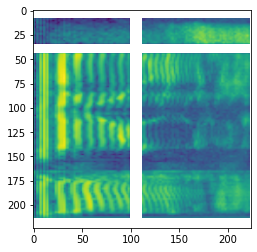

In [123]:
wav = tf.io.read_file(x_train[0])
wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
wav = tf.squeeze(wav, axis=-1)
sr = tf.cast(sr, dtype=tf.int64)
wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)
mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)
plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())
print(mel_spectrogram.shape)

In [135]:
@tf.function(jit_compile=False, reduce_retracing=True)
def preprocess(filepath):
      wav = tf.io.read_file(filepath)
      wav, sr = tf.audio.decode_wav(wav, desired_channels=1)
      wav = tf.squeeze(wav, axis=-1)
      sr = tf.cast(sr, dtype=tf.int64)
      wav = tfio.audio.resample(wav, rate_in=sr, rate_out=sample_rate)
      spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=512, stride=256)
      mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=128, fmin=80, fmax=7600)

      # Augmentations
      mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=10)
      mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)

      # Resizing
      mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
      mel_spectrogram = tf.image.resize_with_pad(mel_spectrogram, target_height=224, target_width=224, method=tf.image.ResizeMethod.BILINEAR)  # any sharper resizing method produce black gaps
      mel_spectrogram = tf.squeeze(tf.stack([mel_spectrogram, mel_spectrogram, mel_spectrogram], axis=-1))
      mel_spectrogram.set_shape([224, 224, 3])
      return mel_spectrogram, tf.argmax(tf.strings.split(filepath, os.path.sep)[-2] == classes)


train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(preprocess, num_parallel_calls=-1)
val_ds = tf.data.Dataset.from_tensor_slices(x_val).map(preprocess, num_parallel_calls=-1)